# Batch Normalization
Ici nous explorerons le concept de batch normalization proposé par [3].  Puisque le code vous est fourni au complet, vous n'avez qu'une question à réponse à la fin de ce fichier.

[3] Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.

In [1]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from ift725.classifiers.fc_net import *
from ift725.data_utils import get_CIFAR10_data
from ift725.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from ift725.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print ('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


## Batch normalization: propagation avant
Dans le fichier `ift725/layers.py`, la fonction `forward_batch_normalization` effectue un propagation avant avec batchnorm.  Assurez-vous de bien comprendre le code. Le code que voici permet d'en tester la validité.

In [3]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization

# Simulate the forward pass for a two-layer network
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print ('Before batch normalization:')
print ('  means: ', a.mean(axis=0))
print ('  stds: ', a.std(axis=0))

# Means should be close to zero and stds close to one
print ('After batch normalization (gamma=1, beta=0)')
a_norm, _ = forward_batch_normalization(a, np.ones(D3), np.zeros(D3), {'mode': 'train'})
print ('  mean: ', a_norm.mean(axis=0))
print ('  std: ', a_norm.std(axis=0))

# Now means should be close to beta and stds close to gamma
gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
a_norm, _ = forward_batch_normalization(a, gamma, beta, {'mode': 'train'})
print ('After batch normalization (nontrivial gamma, beta)')
print ('  means: ', a_norm.mean(axis=0))
print ('  stds: ', a_norm.std(axis=0))

Before batch normalization:
  means:  [ 10.34606928 -21.62154639 -16.84813313]
  stds:  [29.31046728 24.39187532 30.96696392]
After batch normalization (gamma=1, beta=0)
  mean:  [-1.99423811e-16  1.20459198e-16 -2.44249065e-17]
  std:  [0.99999999 0.99999999 0.99999999]
After batch normalization (nontrivial gamma, beta)
  means:  [11. 12. 13.]
  stds:  [0.99999999 1.99999998 2.99999998]


In [4]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)
for t in range(50):
  X = np.random.randn(N, D1)
  a = np.maximum(0, X.dot(W1)).dot(W2)
  forward_batch_normalization(a, gamma, beta, bn_param)
bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = forward_batch_normalization(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

After batch normalization (test-time):
  means:  [ 0.05325089 -0.02470519 -0.02546463]
  stds:  [1.03607621 0.95691486 1.02813578]


## Batch Normalization: rétro-propagation
la rétro-propagation de batch norm est dans la fonction `backward_batch_normalization`.  Ici aussi, assurez-vous de bien comprendre le code.  La cellule suivante effectue une vérification dilligente du gradient.

In [5]:
# Gradient check batchnorm backward pass

N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: forward_batch_normalization(x, gamma, beta, bn_param)[0]
fg = lambda a: forward_batch_normalization(x, gamma, beta, bn_param)[0]
fb = lambda b: forward_batch_normalization(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = forward_batch_normalization(x, gamma, beta, bn_param)
dx, dgamma, dbeta = backward_batch_normalization(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  8.585364389417257e-09
dgamma error:  1.4289083281816934e-11
dbeta error:  9.51359999450882e-12


## Batch Normalization: alternative backward
Voici une version alternative de la batch norm.

In [6]:
N, D = 100, 500
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
out, cache = forward_batch_normalization(x, gamma, beta, bn_param)

t1 = time.time()
dx1, dgamma1, dbeta1 = backward_batch_normalization(dout, cache)
t2 = time.time()
dx2, dgamma2, dbeta2 = backward_batch_normalization_alternative(dout, cache)
t3 = time.time()

print('dx difference: ', rel_error(dx1, dx2))
print('dgamma difference: ', rel_error(dgamma1, dgamma2))
print('dbeta difference: ', rel_error(dbeta1, dbeta2))
print('speedup: %.2fx' % ((t2 - t1) / (t3 - t2)))

dx difference:  6.568981907521506e-12
dgamma difference:  0.0
dbeta difference:  0.0
speedup: 1.14x


# Question 1

Suivant le code de la fonction forward_batch_normalization expliquez mathématiquement l'opération effectuée en mode train et en mode test

## Votre réponse ...

En mode test :
La sortie de neurones est calculé en appliquant le fully connected entre les entrées de la couches et les poids. On obtient le vecteur de sortie a.
On normalise a, en commençant par calculer la moyenne Mi et la variance MUj de chaque composante. A chaque élément de a, on soustrait la moyenne Mi puis on divise par la racine de la variance MUj de a composante.

On a donc a_normalized = (Aij - Mj) / sqrt(MUj)

Ensuite, on applique un scaling sur tous les éléments en multipliant via l'opération bn = alpha*a_normalized + beta
avec alpha et beta des valeurs arbitraires.

Enfin, la moyenne et la variance gobale du réseau sont mis à jour en utilisant les variables momentum et epsilon :
running_mean = momentum * running_mean + (1 - momentum) * batch_mean
running_var = momentum * running_var + (1 - momentum) * batch_var

En mode test, les paramètres su réseau sont appris. Pour appliquer la normalization, on ne recalcule pas la moyenne et la variance des composantes à chaque couche, on utlise les variables running_mean et running_var entraînées pendant l'apprentisages : 

on a donc a_normalized = (Aij - running_mean) / sqrt(running_var + epsilon), avec epsilon une constante arbitraire proche de 0, et la batch norm de chaque couche :

bn = alpha * a_normalized + beta

# Question 2

Suivant le code de la fonction `backward_batch_normalization` expliquez mathématiquement l'opération effectuée.

## Votre réponse ...

## Réseaux pleinement connectés et Batch Normalization
Maintenant que vous comprenez en quoi consiste la *batch normalization*, allez dans votre classe `FullyConnectedNeuralNet` du fichier `ift725/classifiers/fc_net.py` et modifiez le code afin d'include la batch normalization à vos réseaux de neurones.

Plus spécifiquement, lorsque la variable `use_batchnorm` est à `True` dans le constructeur, vous devriez ajouter une couche *batch norma*  **avant** chaque couche ReLU. De plus, la sortie de la dernière couche **ne doit pas** être normalisée. Une fois fait, vérifiez votre implantation avec le code que voici.


In [7]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print ('Running check with reg = ', reg)
  model = FullyConnectedNeuralNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64,
                            use_batchnorm=True)

  loss, grads = model.loss(X, y)
  print ('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  if reg == 0: print

Running check with reg =  0
Initial loss:  2.3014642295020016
W1 relative error: 9.08e-07
W2 relative error: 7.13e-07
W3 relative error: 4.19e-08
b1 relative error: 1.50e-07
b2 relative error: 5.69e-09
b3 relative error: 1.61e-10
Running check with reg =  3.14
Initial loss:  11.359943755051948
W1 relative error: 2.82e-08
W2 relative error: 1.72e-07
W3 relative error: 1.31e-08
b1 relative error: 5.47e-08
b2 relative error: 4.37e-09
b3 relative error: 7.13e-10


Exécutez ce code pour entraîner un réseau de neurones à 6 couches sur 1000 images de CIFAR10 avec et sans batch normalization.

In [8]:
# Try training a very deep net with batchnorm
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 2e-2
bn_model = FullyConnectedNeuralNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
model = FullyConnectedNeuralNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

bn_solver = Solver(bn_model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
bn_solver.train()

solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
solver.train()

(Iteration 1 / 200) loss: 2.302864
(Epoch 0 / 10) train acc: 0.168000; val_acc: 0.154000
(Epoch 1 / 10) train acc: 0.226000; val_acc: 0.222000
(Epoch 2 / 10) train acc: 0.263000; val_acc: 0.218000
(Epoch 3 / 10) train acc: 0.371000; val_acc: 0.304000
(Epoch 4 / 10) train acc: 0.434000; val_acc: 0.325000
(Epoch 5 / 10) train acc: 0.459000; val_acc: 0.332000
(Epoch 6 / 10) train acc: 0.505000; val_acc: 0.327000
(Epoch 7 / 10) train acc: 0.550000; val_acc: 0.308000
(Epoch 8 / 10) train acc: 0.609000; val_acc: 0.308000
(Epoch 9 / 10) train acc: 0.683000; val_acc: 0.346000
(Epoch 10 / 10) train acc: 0.704000; val_acc: 0.329000
(Iteration 1 / 200) loss: 2.302709
(Epoch 0 / 10) train acc: 0.102000; val_acc: 0.084000
(Epoch 1 / 10) train acc: 0.288000; val_acc: 0.226000
(Epoch 2 / 10) train acc: 0.282000; val_acc: 0.242000
(Epoch 3 / 10) train acc: 0.359000; val_acc: 0.286000
(Epoch 4 / 10) train acc: 0.358000; val_acc: 0.257000
(Epoch 5 / 10) train acc: 0.418000; val_acc: 0.285000
(Epoch 6 / 

## Visualisation

/home/yannis/Documents/uds/ift725/.venv_ift725/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/home/yannis/Documents/uds/ift725/.venv_ift725/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/yannis/Documents/uds/ift725/.venv_ift725/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: Matpl

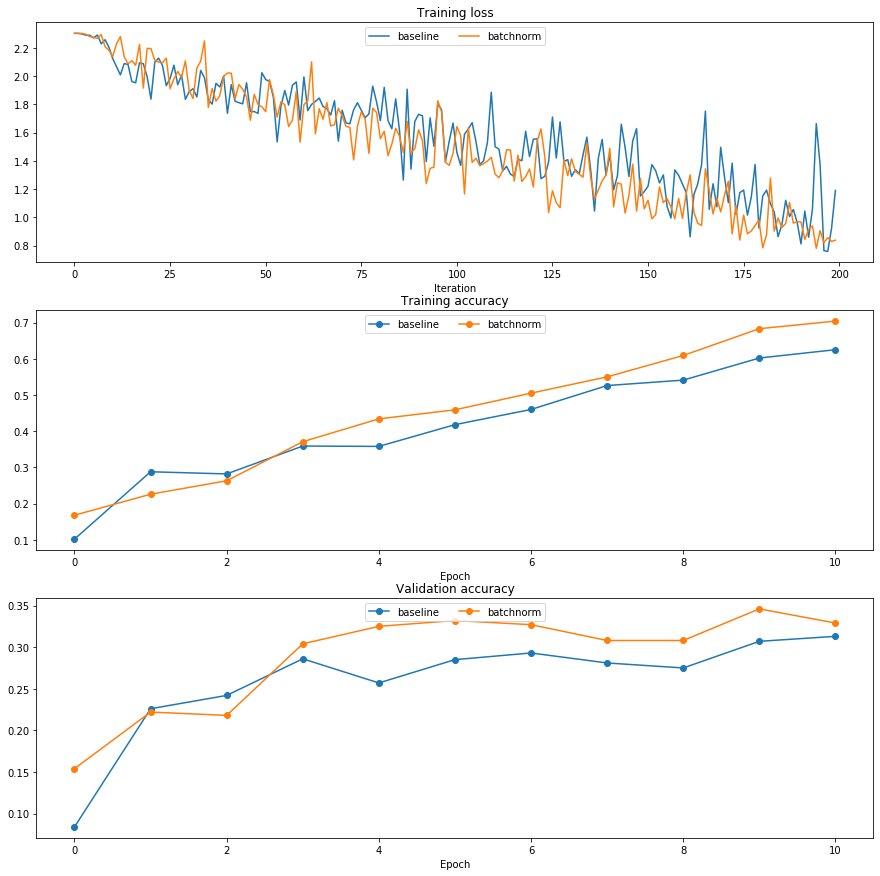

In [9]:
plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 1)
plt.plot(solver.loss_history, '-', label='baseline')
plt.plot(bn_solver.loss_history, '-', label='batchnorm')

plt.subplot(3, 1, 2)
plt.plot(solver.train_acc_history, '-o', label='baseline')
plt.plot(bn_solver.train_acc_history, '-o', label='batchnorm')

plt.subplot(3, 1, 3)
plt.plot(solver.val_acc_history, '-o', label='baseline')
plt.plot(bn_solver.val_acc_history, '-o', label='batchnorm')
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Batch normalization et initialisation
Les dernières cellules de ce notebook a pour objectif d'illustrer l'intéraction qu'il y a entre *batch norm* et l'initialisation d'un réseau de neurones.

Dans la première cellule nous entraînerons un réseau à 8 couches avec et sans *batch normalization* avec différentes échelles (*scales*) d'initialisation des poids. Ensuite nous afficherons la justesse en entrainement, en validation ainsi que la perte obtenues pour différents échelles d'initialisation.

In [10]:
# Try training a very deep net with batchnorm
hidden_dims = [50, 50, 50, 50, 50, 50, 50]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

bn_solvers = {}
solvers = {}
weight_scales = np.logspace(-4, 0, num=20)
for i, weight_scale in enumerate(weight_scales):
  print('Running weight scale %d / %d' % (i + 1, len(weight_scales)))
  bn_model = FullyConnectedNeuralNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
  model = FullyConnectedNeuralNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

  bn_solver = Solver(bn_model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
  bn_solver.train()
  bn_solvers[weight_scale] = bn_solver

  solver = Solver(model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
  solver.train()
  solvers[weight_scale] = solver

Running weight scale 1 / 20
Running weight scale 2 / 20
Running weight scale 3 / 20
Running weight scale 4 / 20
Running weight scale 5 / 20
Running weight scale 6 / 20
Running weight scale 7 / 20
Running weight scale 8 / 20
Running weight scale 9 / 20
Running weight scale 10 / 20
Running weight scale 11 / 20
Running weight scale 12 / 20
Running weight scale 13 / 20
Running weight scale 14 / 20
Running weight scale 15 / 20
Running weight scale 16 / 20


/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:701: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


Running weight scale 17 / 20
Running weight scale 18 / 20
Running weight scale 19 / 20
Running weight scale 20 / 20


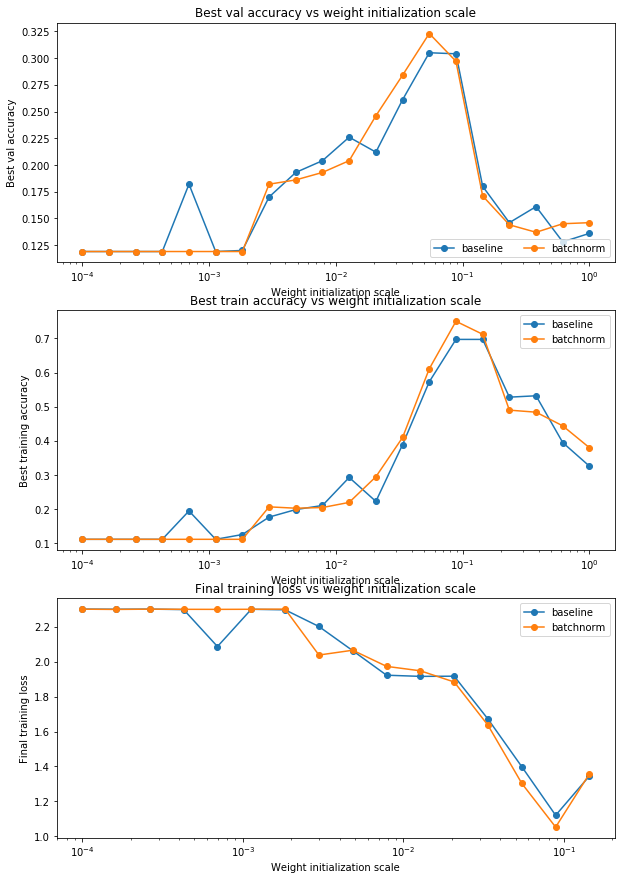

In [11]:
# Plot results of weight scale experiment
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
  best_train_accs.append(max(solvers[ws].train_acc_history))
  bn_best_train_accs.append(max(bn_solvers[ws].train_acc_history))
  
  best_val_accs.append(max(solvers[ws].val_acc_history))
  bn_best_val_accs.append(max(bn_solvers[ws].val_acc_history))
  
  final_train_loss.append(np.mean(solvers[ws].loss_history[-100:]))
  bn_final_train_loss.append(np.mean(bn_solvers[ws].loss_history[-100:]))
  
plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()

plt.gcf().set_size_inches(10, 15)
plt.show()

# Question 3:
Quelle(s) conclusion(s) tirez-vous de ces courbes?

## Votre réponse:...
